In [1]:
%load_ext autoreload
%autoreload 2
CUDA_LAUNCH_BLOCKING=1

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLP

import torch
import torchsde
from torch import vmap
from torchdiffeq import odeint

from src.energies.gmm_energy import GMM
from fab.target_distributions import gmm

from src.energies.base_prior import Prior, MeanFreePrior

from src.models.components.clipper import Clipper

from torch.func import hessian
from math import sqrt
from src.utils.data_utils import remove_mean
from math import sqrt, log

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [4]:
import torch

def product_of_gaussians(mu1, sigma1, mu2, sigma2, log_weights):
    EPS = 1e-6

    var1 = sigma1 ** 2
    var2 = sigma2 ** 2

    denom = var1 + var2
    mu_prod = (mu1 * var2 + mu2 * var1) / denom
    var_prod = (var1 * var2) / denom
    std_prod = var_prod**0.5

    diff = mu1 - mu2

    log_weights = (log_weights -
                   0.5 * torch.log(2 * np.pi * torch.prod(denom)) +
                   torch.sum(-diff**2 / (2 * denom), dim=-1))
    

    return mu_prod, std_prod, log_weights


def gmm_product(gmm1, gmm2):
    means_1 = gmm1.gmm.locs
    scale_trils_1 = gmm1.gmm.scale_trils
    weights_1 = gmm1.gmm.cat_probs

    means_2 = gmm2.gmm.locs
    scale_trils_2 = gmm2.gmm.scale_trils
    weights_2 = gmm2.gmm.cat_probs

    K_1 = means_1.shape[0]
    K_2 = means_2.shape[0]

    new_weights = []
    new_means = []
    new_stds = []

    for i in range(K_1):
        for j in range(K_2):
            mu1, sigma1 = means_1[i], torch.diagonal(scale_trils_1[i], dim1=-2, dim2=-1)
            mu2, sigma2 = means_2[j], torch.diagonal(scale_trils_2[i], dim1=-2, dim2=-1)
            log_weights1, log_weights2 = weights_1[i], weights_2[j]

            # Product of two Gaussians
            mu_prod, std_prod, z = product_of_gaussians(mu1, sigma1, mu2, sigma2,
                                                        log_weights1 + log_weights2)

            # New weight
            new_weights.append(z)
            new_means.append(mu_prod)
            new_stds.append(std_prod)

    # Stack results into tensors
    new_weights = torch.stack(new_weights).to(gmm1.device)
    new_means = torch.stack(new_means).to(gmm1.device)
    new_stds = torch.stack(new_stds).to(gmm1.device)

    # drop modes with small logprob
    mask = torch.softmax(new_weights, dim=-1)>1e-4
    new_weights = new_weights[mask]
    new_means = new_means[mask]
    new_stds = new_stds[mask]

    product_gmm = GMM(dimensionality=gmm1.dimensionality,
                      n_mixes=new_means.shape[0],
                      loc_scaling= 1.0,
                      log_var_scaling=1.0,
                      mean=new_means,
                      scale=new_stds,
                      cat_probs=new_weights,
                      device=device,
                      should_unnormalize=True,
                      temperature=1.0
                      )

    return product_gmm

In [5]:
dimensionality = 2
temperature = 1.0
annealed_temperature = 1/2
inverse_temperature = temperature / annealed_temperature # beta in the paper

target = GMM(dimensionality=dimensionality,
                   n_mixes=40,
                   loc_scaling= 40.0,
                   log_var_scaling=2.0,
                   device=device,
                   should_unnormalize=True,
                   temperature=temperature
                   )

# annealed_target = gmm_product(target, gmm_product(target, target))
annealed_target = gmm_product(target, target)
# target = target_temp2 #gmm_product(target_temp1, target_temp2)


samples = {}
energies = {}
test_samples = annealed_target.sample_test_set(3000)
samples["Test"] = annealed_target.normalize(test_samples).detach()

In [6]:
annealed_target.gmm.locs.shape

torch.Size([118, 2])

In [7]:
# mask= (torch.softmax(annealed_target.gmm.cat_probs, dim=-1)>1e-3)
# masked_means = annealed_target.gmm.locs[mask]

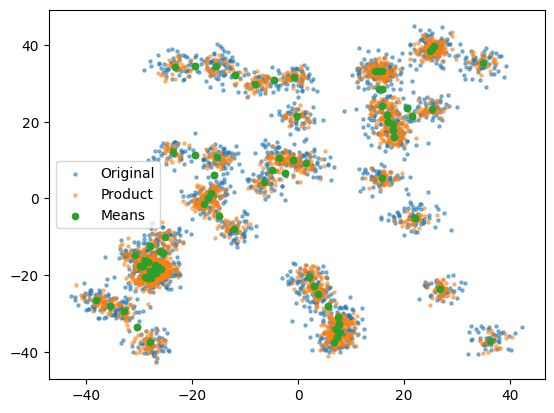

In [8]:
a = target.sample_test_set(2000)
b = annealed_target.sample_test_set(2000)

plt.scatter(a[:, 0].detach().cpu(), a[:, 1].detach().cpu(), label="Original", alpha=0.5, s=5)
plt.scatter(b[:, 0].detach().cpu(), b[:, 1].detach().cpu(), label="Product", alpha=0.5, s=5)
plt.scatter(annealed_target.gmm.locs[:, 0].cpu(),annealed_target.gmm.locs[:, 1].cpu(), label="Means", s=20)
plt.legend()

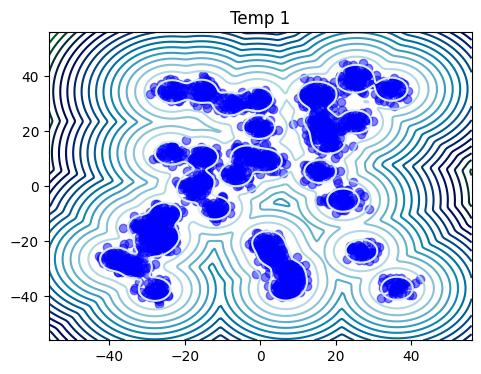

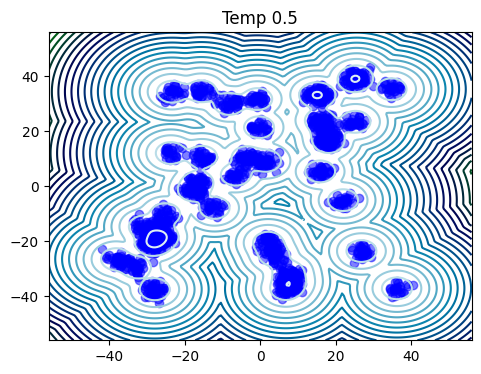

In [9]:
target.get_dataset_fig(a, title="Temp 1")
plt.show()
annealed_target.get_dataset_fig(b, title="Temp 0.5")
plt.show()

## Functions

### Utils

In [10]:
class VPSchedule():
    def __init__(self, beta_min, beta_max):
        self.beta_min = beta_min
        self.beta_max = beta_max

    def beta(self, t):
        # beta = -2 * d/dt log_alpha
        return  self.beta_min + (self.beta_max - self.beta_min) * t

    def log_mean_coeff(self, t): #log_alpha
        return -0.25 * t**2 * (self.beta_max - self.beta_min) - 0.5 * t * self.beta_min
    
    # ddt log_mean_coeff = -0.5 * t * (beta_max - beta_min) - 0.5 * beta_min

    def h(self, t): #variance
        return (1.0 - torch.exp(2.0 * self.log_mean_coeff(t)))
    
    def log_mean(self, t):
        return torch.exp(self.log_mean_coeff(t))

In [11]:
def compute_laplacian(model, target, t, xt, noise_schedule): 
    def func_wrap(t, xt):
        return model(target, xt.unsqueeze(0), t.unsqueeze(0), noise_schedule).squeeze()

    # Calculate the Hessian matrix of the model output with respect to the input
    hessian_matrix = vmap(torch.func.jacrev(func_wrap, argnums=1))(t, xt)

    # Calculate the Laplacian as the trace of the Hessian matrix
    laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    return laplacian.detach()

In [12]:
def true_Ut(target, x, t, noise_schedule, ve=True):
    h_t = noise_schedule.h(t).to(device)
    mean_coeff = None
    if not ve:
        mean_coeff = noise_schedule.log_mean(t).to(device)
    target.gmm.convolve(h_t * (target.data_normalization_factor**2), t, var_exploding=ve, mean_coeff=mean_coeff)
    energy = target(x)
    target.gmm.reset()
    return energy

In [13]:
def true_nabla_Ut(target, x, t, noise_schedule, ve=True):
    nabla_Ut = torch.func.jacrev(true_Ut, argnums=1)(target, x, t, noise_schedule, ve)
    return nabla_Ut

In [14]:
from scipy.stats import qmc
sampler = qmc.Sobol(d=1, scramble=False)

def sample_cat(bs, next_u, logits):
    # u, next_u = sample_uniform(bs, next_u)
    u = sampler.random(bs).squeeze()
    bins = torch.cumsum(torch.softmax(logits, dim=-1), dim=-1)
    ids = np.digitize(u, bins.cpu())
    ids = torch.tensor(ids, dtype=torch.long).to(device)
    return ids, next_u


def sample_cat_sys(bs, logits):
    u = torch.rand(size=(1,))
    u = (u + 1/bs*torch.arange(bs)) % 1
    clipped_weights = torch.clip(torch.softmax(logits, dim=-1), 1e-6, 1.0)
    bins = torch.cumsum(clipped_weights, dim=-1)
    ids = np.digitize(u, bins.cpu(), right=True)

    ids[ids == len(bins)] = ids[ids == len(bins)] - 1

    # check if value falls outside of last bin

    # print number of unique ids
    # ids = torch.tensor(ids, dtype=torch.long).to(device)
    # print(len(torch.unique(ids)))
    return ids, None

### SDEs

In [15]:
class VEReverse_coupled(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, noise_schedule, temperature_schedule, scale_diffusion=False):
        super().__init__()
        self.noise_schedule = noise_schedule
        self.temperature_schedule = temperature_schedule
        self.scale_diffusion = scale_diffusion


    def f(self, t, x, resampling_interval=None):
        beta_t = self.temperature_schedule.beta(t)
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)

            nabla_Ut = torch.vmap(true_nabla_Ut, in_dims=(None, 0, 0, None))(target, x, t, self.noise_schedule)
            self.nabla_logqt = nabla_Ut

            if self.scale_diffusion:
                drift_X = (beta_t+1)/2 * nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)
            else:
                drift_X = beta_t * nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

            drift_A = torch.zeros(x.shape[0]).to(x.device)

            if resampling_interval is None:
                return  drift_X.detach(), drift_A.detach(), nabla_Ut.detach()
            
            drift_A = 0.5 * ((self.g(t, x)[:,None] * nabla_Ut).pow(2).sum(-1) 
                             * (beta_t-1) * beta_t)

        return  drift_X.detach(), drift_A.detach(), nabla_Ut.detach()

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

    def diffusion(self, t, x, diffusion_scale=1.0):
        beta_t = self.temperature_schedule.beta(t)
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones_like(x).to(x.device)

        self.noise = torch.randn_like(x).to(x.device)
        diffusion = diffusion_scale * self.g(t, x) * self.noise 

        if self.scale_diffusion:
            return (diffusion / torch.sqrt(beta_t))
        return  diffusion
    
    def dlogq_dt(self, t, x, dx, dt):
        # dx = nabla_logq * self.g(t, x).pow(2).unsqueeze(-1) * dt + self.g(t, x) * self.noise * sqrt(dt)
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)
        return (self.nabla_logqt * dx).sum(-1) - 0.5 * (self.g(t, x)[:, None] * self.nabla_logqt).pow(2).sum(-1) * dt
        dwt = self.noise * sqrt(dt)
        return self.g(t, x) * (nabla_logq * dwt).sum(-1) + 0.5 * (self.g(t, x)[:, None] * nabla_logq).pow(2).sum(-1) * dt

### Integrators

In [16]:
from src.models.components.temperature_schedules import LinearInvTempSchedule, ConstantInvTempSchedule

In [17]:
def euler_maruyama_step_coupled(sde, x, t, a, dt, step, resampling_interval,
                                logq=None):
    # Calculate drift and diffusion terms
    drift_Xt, drift_At, nabla_logqt = sde.f(t, x, resampling_interval)
    diffusion = sde.diffusion(t, x)
    dx = drift_Xt * dt + diffusion * np.sqrt(dt)

    dlogq_dt = sde.dlogq_dt(t, x, dx, dt)
    logq_next = logq + dlogq_dt

    # logq_next_true = true_Ut(target, x, t, sde.noise_schedule, ve=True) + log(target.data_normalization_factor**2)
    # print(logq_next[:5] - logq_next_true[:5])
    # print("TRUE", logq_next_true[:5])

    # Update the state
    x_next = x + dx
    a_next = a + drift_At * dt

    if resampling_interval is None or step % resampling_interval != 0:
        return x_next, a_next, logq_next
    
    a_next = a_next + sde.temperature_schedule.dbeta_dt(t) * (logq_next + log(target.data_normalization_factor**2))

    #resample based on the weights
    choice, _ = sample_cat_sys(x.shape[0], a_next)
    a_next = torch.zeros_like(a_next)
    x_next = x_next[choice]
    
    return x_next, a_next, logq_next


def integrate_sde_coupled(sde, x0, t_span, dt, resampling_interval, logq=None):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    logqs = []
    a = torch.zeros(x.shape[0]).to(device)
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a, logq = euler_maruyama_step_coupled(sde, x, 1-t, a, dt, step+1, resampling_interval, logq=logq)
            if target.is_molecule:
                x = remove_mean(x, target.n_particles, target.n_spatial_dim)
            samples.append(x)
            logweights.append(a)
            logqs.append(logq)

    logqs = torch.stack(logqs)
    return torch.stack(samples), torch.stack(logweights), logqs

def generate_samples_weighted(reverse_sde, t_span=(0, 1), num_integration_steps=100,
                              samples=None, num_samples=200, resampling_interval=None,
                              prior=None, compute_logq=False):
    if samples is None:
        if prior is None:
            raise ValueError("Either samples or prior distribution should be provided")
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights, logqs = integrate_sde_coupled(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        resampling_interval = resampling_interval,
        logq = prior.log_prob(samples)
    )
    if compute_logq:
        return samples, weights, logqs
    else:
        return samples[-1], weights

## Sampling

### Variance Exploding SDE

In [18]:
from src.models.components.noise_schedules import GeometricNoiseSchedule, QuadraticNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=0.1, sigma_max=10 * sqrt(temperature))

#noise_schedule = QuadraticNoiseSchedule(beta=10)

In [19]:
num_int_steps = 1000 
num_samples = 5000
num_seeds = 1

prior = Prior(2, device=device, scale = noise_schedule.h(1) ** 0.5)
prior_samples = prior.sample(num_samples)

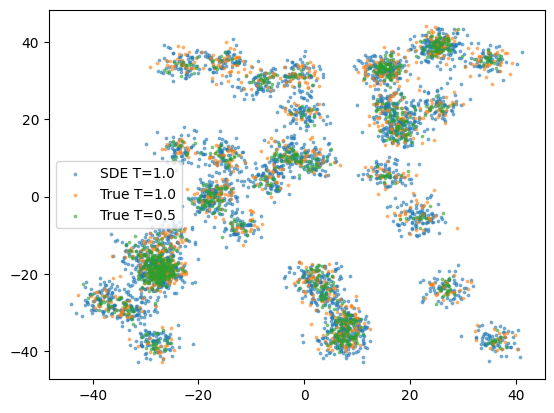

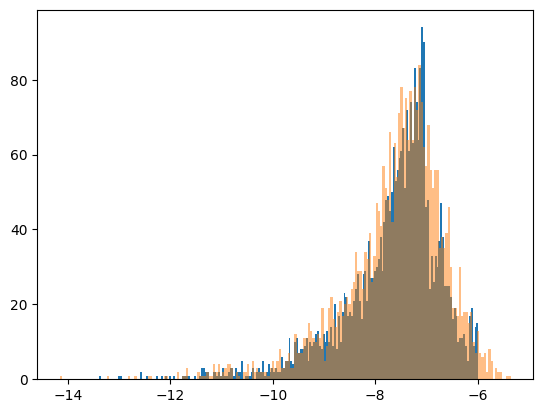

In [20]:
# Test Ito density Estimation

temperature_schedule = ConstantInvTempSchedule(1.0)
ve_reverse_sde = VEReverse_coupled(noise_schedule, scale_diffusion=False, temperature_schedule=temperature_schedule)
samples_hightemp, _, logq = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=num_int_steps,
                                                resampling_interval=None, num_samples=num_samples,
                                                samples=prior_samples, prior=prior, compute_logq=True)
samples_energy = target(samples_hightemp)
# target.get_dataset_fig(target.unnormalize(samples_hightemp), T=1.0, title=f"Temperature {temperature}")
samples_hightemp_unnorm = target.unnormalize(samples_hightemp).detach().cpu().numpy()
plt.scatter(samples_hightemp_unnorm[:, 0], samples_hightemp_unnorm[:, 1], s=3, label=f"SDE T={temperature}" , alpha=0.5)

s = target.sample_test_set(1000).detach().cpu().numpy()
plt.scatter(s[:, 0], s[:, 1], s=3, label=f"True T={temperature}", alpha=0.5)

s = annealed_target.sample_test_set(1000).detach().cpu().numpy()
plt.scatter(s[:, 0], s[:, 1], s=3, label=f"True T={annealed_temperature}", alpha=0.5)

plt.legend()
plt.show()

plt.hist(samples_energy.detach().cpu(), bins=200);
plt.hist((logq[-1].detach().cpu()) - log(target.data_normalization_factor**2), bins=200, alpha=0.5);

In [20]:
# temperature_schedule = ConstantInvTempSchedule(inverse_temperature)
temperature_schedule = LinearInvTempSchedule(inverse_temperature, inverse_temp_start=1.5)
# temperature_schedule = ExponentialInvTempSchedule(inverse_temperature)

annealed_prior = Prior(2, device=device, scale = (noise_schedule.h(1) / temperature_schedule.beta(1)) ** 0.5)
annealed_prior_samples = annealed_prior.sample(num_samples)

# Resampling v1
s = []
for seed in range(num_seeds):
    ve_reverse_sde = VEReverse_coupled(noise_schedule,
                                       temperature_schedule=temperature_schedule,
                                       scale_diffusion=False)

    samples_resampled, log_weights, logqs = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1),
                                                               samples=annealed_prior_samples,
                                                               prior=annealed_prior,
                                                               num_integration_steps=num_int_steps,
                                                               resampling_interval=1,
                                                               compute_logq=True
                                                               )
    # annealed_target.get_dataset_fig(annealed_target.unnormalize(samples_resampled),
    #                     title="Resampling")
    # plt.show()
    # plt.plot(torch.linspace(1, 0, num_int_steps), log_weights.cpu().detach().numpy()[:, :20])
    # plt.xlabel("Integration Time")
    # plt.ylabel("dlogW")
    # plt.show()

#     samples_resampled = samples_resampled.detach()
#     s.append(samples_resampled)


# samples["ve_resampled"] = torch.stack(s)

In [32]:
(logqs.detach().cpu()[10]+20).min()

tensor(5.0947)

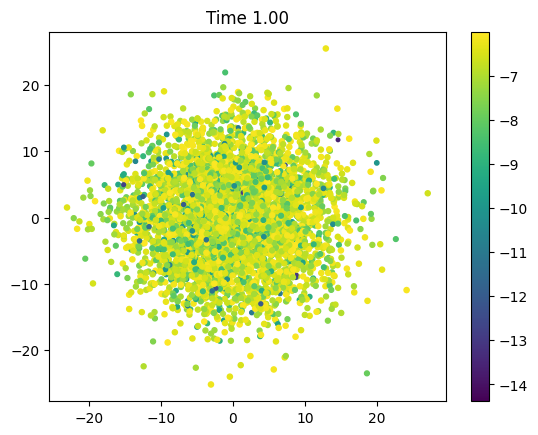

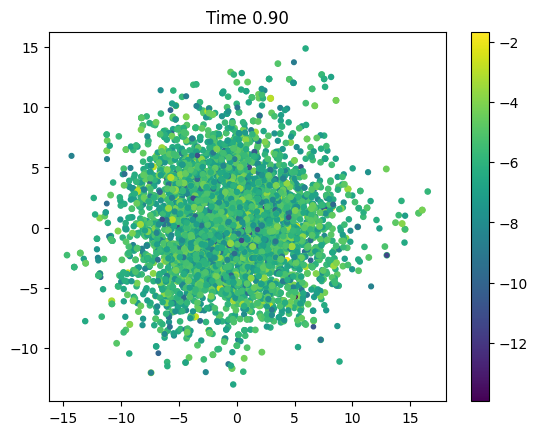

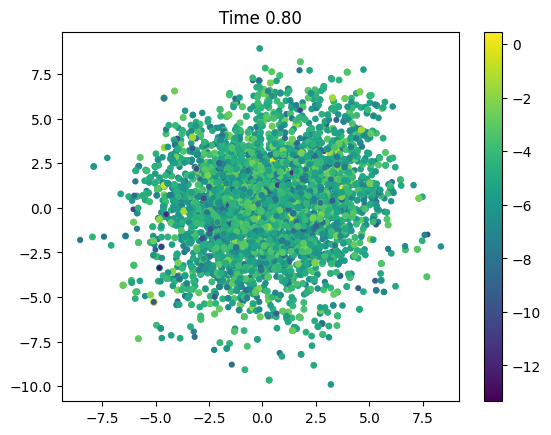

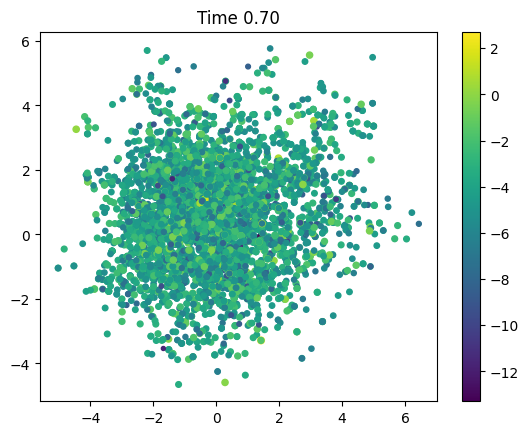

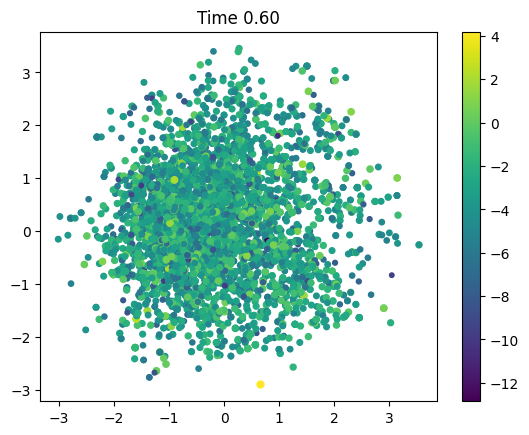

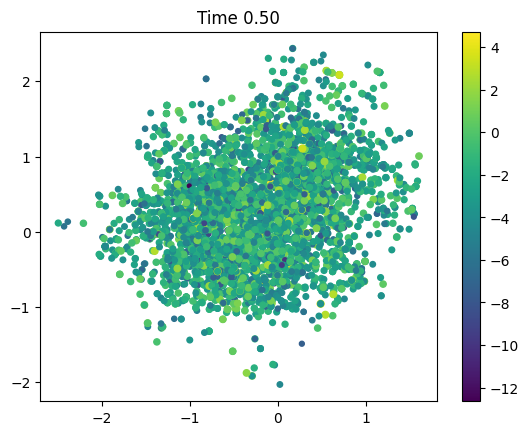

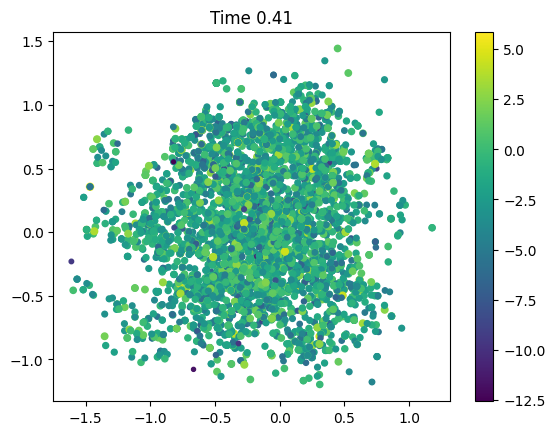

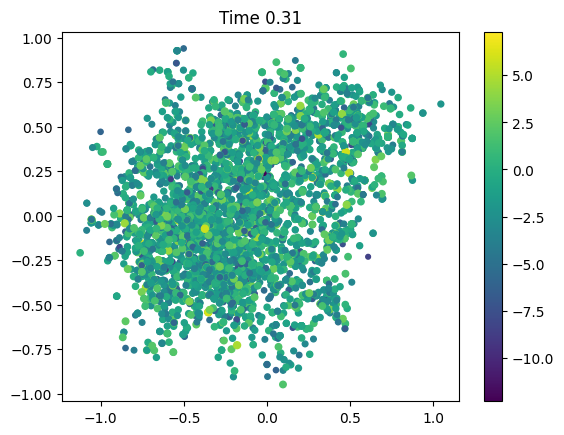

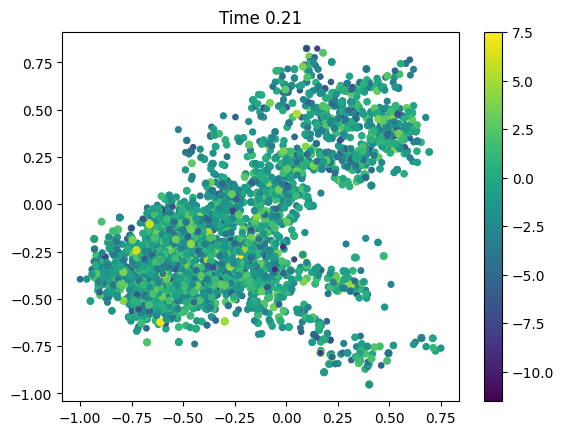

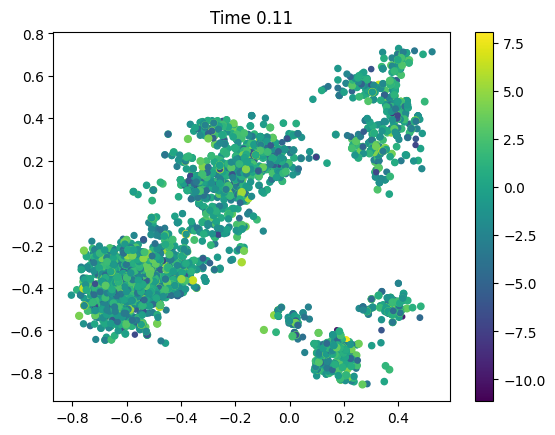

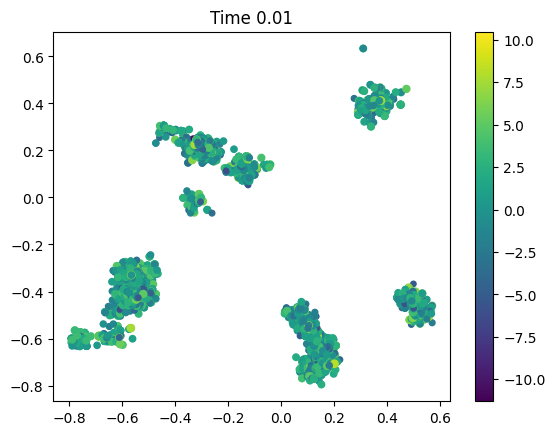

In [27]:
times = torch.linspace(1, 0, num_int_steps)
for i in range(num_int_steps+1):     
    if i % 99 == 0:                                        
        # annealed_target.get_dataset_fig(annealed_target.unnormalize(samples_resampled[i]),
        #                     title=f"Time {times[i]:.2f}", color=logqs.cpu()[i]);
        plt.scatter(samples_resampled[i][:, 0].detach().cpu(), samples_resampled[i][:, 1].detach().cpu(), label=f"Time {times[i]:.2f}",
        c=logqs.detach().cpu()[i], s=logqs.detach().cpu()[i]+20)
        plt.title(f"Time {times[i]:.2f}")
        plt.colorbar()
        plt.show()

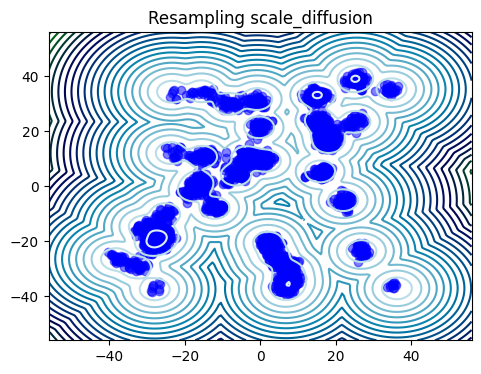

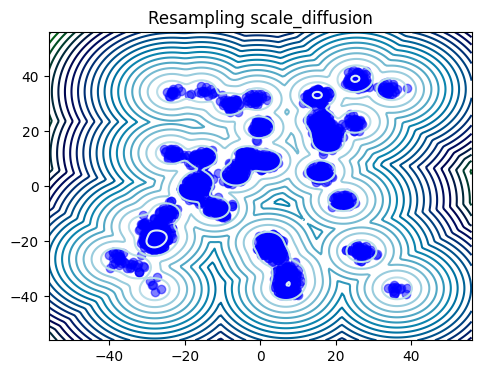

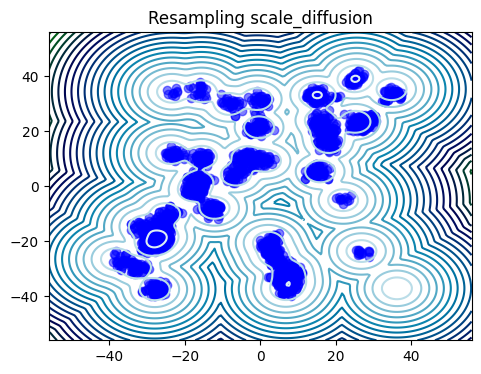

In [86]:
# Resampling v2
# temperature_schedule = ConstantInvTempSchedule(inverse_temperature)
temperature_schedule = LinearInvTempSchedule(inverse_temperature, inverse_temp_start=2.01)
annealed_prior = Prior(2, device=device, scale = (noise_schedule.h(1) / temperature_schedule.beta(1)) ** 0.5)
annealed_prior_samples = annealed_prior.sample(num_samples)


s = []
for seed in range(3):
    ve_reverse_sde = VEReverse_coupled(noise_schedule,
                                       temperature_schedule=temperature_schedule,
                                       scale_diffusion=True)

    samples_resampled, log_weights = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1),
                                                               samples=annealed_prior_samples,
                                                               prior=annealed_prior,
                                                               num_integration_steps=num_int_steps,
                                                               resampling_interval=1
                                                               )
    annealed_target.get_dataset_fig(annealed_target.unnormalize(samples_resampled),
                        title="Resampling scale_diffusion")
    plt.show()
    # plt.plot(torch.linspace(1, 0, num_int_steps), log_weights.cpu().detach().numpy()[:, :20])
    # plt.xlabel("Integration Time")
    # plt.ylabel("dlogW")
    # plt.show()

    samples_resampled = samples_resampled.detach()
    s.append(samples_resampled)

samples["ve_resampled, scale_diffusion"] = torch.stack(s)

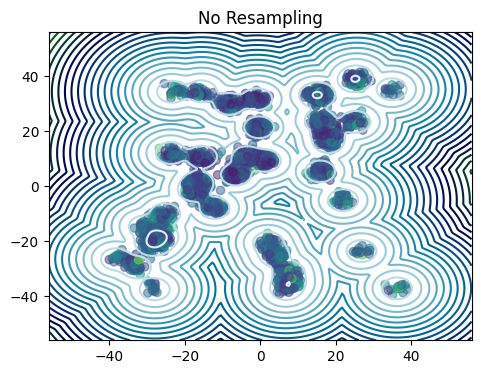

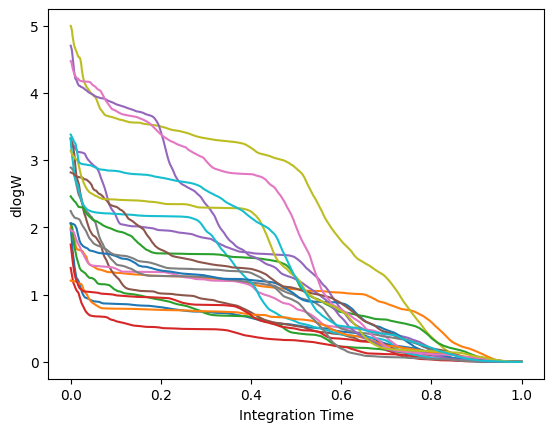

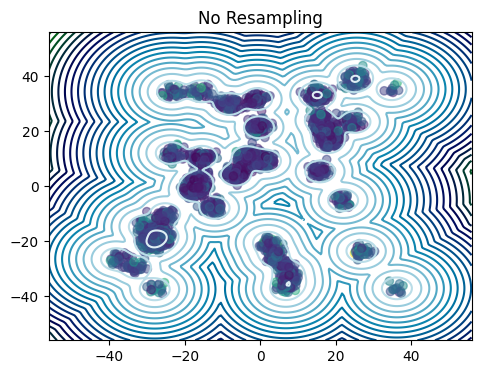

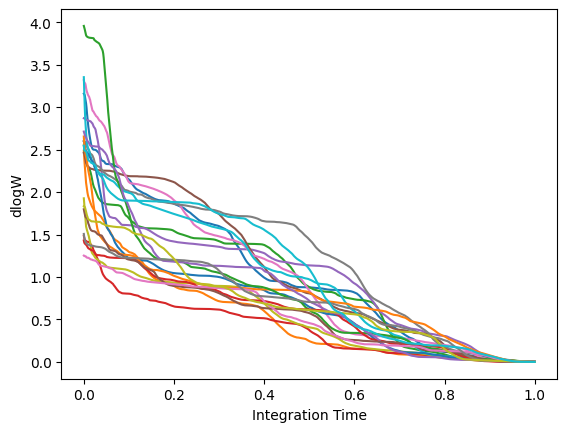

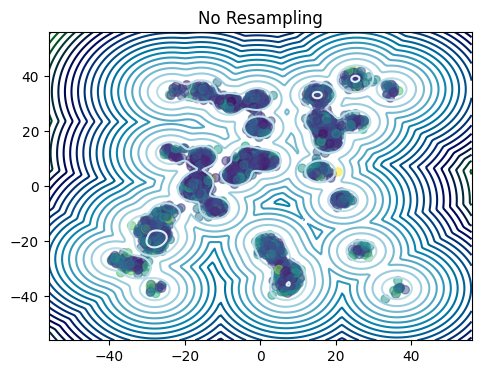

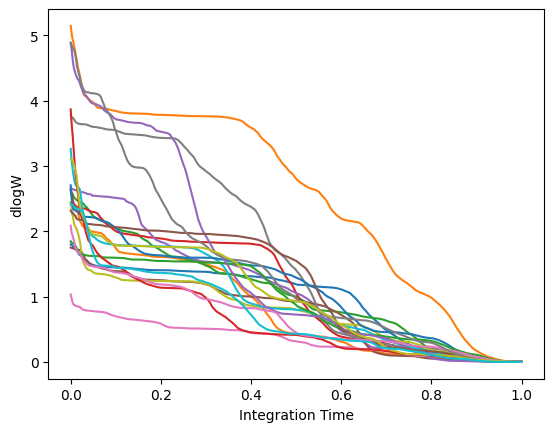

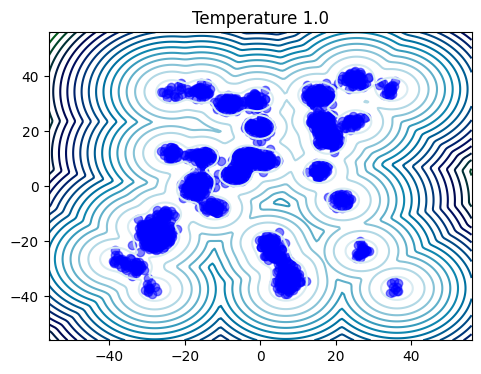

In [82]:
# temperature_schedule = ConstantInvTempSchedule(inverse_temperature)
temperature_schedule = LinearInvTempSchedule(inverse_temperature)
annealed_prior = Prior(2, device=device, scale = (noise_schedule.h(1) / temperature_schedule.beta(1)) ** 0.5)
annealed_prior_samples = annealed_prior.sample(num_samples)

# No Resampling
s = []
for seed in range(3):
    ve_reverse_sde = VEReverse_coupled(noise_schedule,
                                       temperature_schedule=temperature_schedule,
                                       scale_diffusion=False)
    samples_not_resampled, log_weights = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1),
                                                                   samples=annealed_prior_samples,
                                                                   prior=annealed_prior,
                                                                   num_integration_steps=num_int_steps,
                                                                   resampling_interval=num_int_steps+1)
    annealed_target.get_dataset_fig(annealed_target.unnormalize(samples_not_resampled), color=log_weights.cpu()[-1],
                        title="No Resampling")
    plt.show()
    plt.plot(torch.linspace(1, 0, num_int_steps), log_weights.cpu().detach().numpy()[:, :20])
    plt.xlabel("Integration Time")
    plt.ylabel("dlogW")
    plt.show()

    samples_not_resampled = samples_not_resampled.detach()
    s.append(samples_not_resampled)

samples["ve not_resampled"] = torch.stack(s)


# Generate samples at high temprature
samples_hightemp, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1),
                                                samples=prior_samples,
                                                prior=prior,
                                                num_integration_steps=num_int_steps,
                                                resampling_interval=None, num_samples=num_samples,
                                                )
samples_energy = target(samples_hightemp)
target.get_dataset_fig(target.unnormalize(samples_hightemp), T=1.0, title=f"Temperature {temperature}")
# samples_hightemp_unnorm = target.unnormalize(samples_hightemp).detach().cpu().numpy()
# plt.scatter(samples_hightemp_unnorm[:, 0], samples_hightemp_unnorm[:, 1], s=3)
plt.show()


In [ ]:
# plt.scatter(torch.linspace(1, 0, num_int_steps), log_weights.std(-1).cpu())
# plt.xlabel("Integration Time")
# plt.ylabel("Standard Deviation of dlogW")

### Metrics

In [ ]:
from src.models.components.distribution_distances import eot
from src.models.components.mmd import linear_mmd2, mix_rbf_mmd2, poly_mmd2
from src.models.components.optimal_transport import wasserstein
import ot as pot

def compute_sample_based_metrics(a, b, a_energy, b_energy):
    w1 = wasserstein(a.double(), b.double(), power=1)
    w2 = wasserstein(a.double(), b.double(), power=2)
    mmd_rbf = mix_rbf_mmd2(a, b, sigma_list=10 ** np.linspace(-2, 0, 10)).item()

    H_b, x_b, y_b = np.histogram2d(b[:, 0].cpu().numpy(), b[:, 1].cpu().numpy(), bins=200)
    H_a, x_a, y_a = np.histogram2d(a[:, 0].cpu().numpy(), a[:, 1].cpu().numpy(), bins=(x_b, y_b))
    total_var = 0.5 * np.abs(H_a/H_a.sum() - H_b/H_b.sum()).sum()

    energy_w2 = pot.emd2_1d(
    a_energy,
    b_energy,
    ).detach().cpu().item()
    return w1, w2, mmd_rbf, total_var, energy_w2

In [ ]:
# test_samples = target_temp1.sample_test_set(1000)
# samples_resampled = samples_resampled.detach()
# samples_not_resampled = samples_not_resampled.detach()

# samples_resampled = target_temp1.unnormalize(samples_resampled)
# samples_not_resampled = target_temp1.unnormalize(samples_not_resampled)

# plt.scatter(samples_resampled[:, 0].cpu(), samples_resampled[:, 1].cpu(), s=3)
# plt.scatter(test_samples[:, 0].cpu(), test_samples[:, 1].cpu(), s=3)
# plt.scatter(samples_not_resampled[:, 0].cpu(), samples_not_resampled[:, 1].cpu(), s=3)
# plt.show()

In [ ]:
for key in samples.keys():
    e = []
    for seed in range(3):
        energy = annealed_target(samples[key][seed]).detach()
        e.append(energy)
    energies[key] = torch.stack(e)

In [ ]:
data_df = []
metrics= ["W1", "W2", "MMD", "Total Var", "Energy W2"]
for key in samples.keys():
    if key == "Test":
        continue
    for seed in range(3):
        data_df.append([key, *compute_sample_based_metrics(annealed_target.unnormalize(samples[key][seed]),
                                                           annealed_target.unnormalize(samples["Test"]),
                                                           energies[key][seed], energies["Test"])])

In [ ]:
import pandas as pd
df = pd.DataFrame(data_df)
df.columns = ["Method"] + metrics

In [ ]:
df.groupby("Method").mean()
# show mean and std
df.groupby("Method").agg([np.mean, np.std])

/tmp/ipykernel_194980/3960333430.py:3: FutureWarning: The provided callable <function mean at 0x7f46515bbd90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby("Method").agg([np.mean, np.std])
/tmp/ipykernel_194980/3960333430.py:3: FutureWarning: The provided callable <function std at 0x7f46515bbeb0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby("Method").agg([np.mean, np.std])
/tmp/ipykernel_194980/3960333430.py:3: FutureWarning: The provided callable <function mean at 0x7f46515bbd90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby("Method").agg([np.mean, np.std])


W1                   W2            \
                                   mean       std       mean       std   
Method                                                                   
ve not_resampled               8.009323  0.078296  11.352020  0.190721   
ve_resampled                   5.588192  3.415864   9.046247  4.615176   
ve_resampled, scale_diffusion  5.515659  1.684299   8.902743  1.924670   

                                    MMD           Total Var            \
                                   mean       std      mean       std   
Method                                                                  
ve not_resampled               0.011569  0.000183  0.642444  0.006769   
ve_resampled                   0.008293  0.001648  0.635003  0.008813   
ve_resampled, scale_diffusion  0.008854  0.000963  0.637333  0.004807   

                              Energy W2            
                                   mean       std  
Method                                             
ve not_resampled               1.366589  0.009280  
ve_resampled                   1.294227  0.187169  
ve_resampled, scale_diffusion  1.434365  0.067060